In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

from scipy.optimize import fmin_cg, minimize
import h5py
from wobble.code.wobble import *
from wobble.code.utils import fit_continuum
import copy
from twobody.wrap import cy_rv_from_elements
c = 2.99792458e8   # m/s

In [12]:
starid = 'hip30037'
a = star(starid+'_e2ds.hdf5', orders=np.arange(72), N=25)
a.load_results('../results/'+starid+'_results.hdf5')
N_epochs = 25
a.rvs_star = np.asarray(a.rvs_star)[:,:N_epochs] # just in case
a.ivars_star = np.asarray(a.ivars_star)[:,:N_epochs]
a.bervs = a.bervs[:N_epochs]
a.N = N_epochs

a.optimize_sigmas()

optimize_sigmas: optimizing...
         Current function value: 5715.184968
         Iterations: 495
         Function evaluations: 37741
         Gradient evaluations: 510


In [78]:
def pack_keplerian_pars(P, K, e, omega, M0, offset):
    return [P, K, e, omega, M0, offset]
    
def unpack_keplerian_pars(pars):
    P, K, e, omega, M0, offset = pars
    return P, K, e, omega, M0, offset

def opposite_lnlike_keplerian(pars, times, rvs, sigs):
    P, K, e, omega, M0, offset = unpack_keplerian_pars(pars)
    t0 = np.min(times)
    ys = cy_rv_from_elements(times, P, K, e, omega, M0, t0, 1e-10, 128)
    if np.any(np.isnan(ys)):
        return np.inf
    ys += offset
    lnlike = -0.5 * np.sum((rvs - ys)**2 / sigs**2)
    return -1.0 * lnlike

def fit_keplerian(pars0, times, rvs, sigs):
    bounds = [(None, None) for par in pars0]
    bounds[2] = (0.0, 1.0)
    pars = minimize(opposite_lnlike_keplerian, pars0, args=(times.astype('<f8'), rvs, sigs), method='L-BFGS-B',
             bounds=bounds, options={'disp':True})['x']
    return pars

In [97]:
rvs = 1.0 * a.drs_rvs - np.median(a.drs_rvs)
#rvs = -1.0 * a.time_rvs
sigs = np.ones_like(rvs) + 9.0 # HACK
P, K, e, omega, M0, offset = 31.6, 4243.8, 0.3, 226. * np.pi / 180., 63. * np.pi / 180., 0.0 # days, m/s, dimensionless, radians, JD
t0 = np.min(a.dates)

In [98]:
from twobody import KeplerOrbit
from astropy.time import Time
import astropy.units as u

In [99]:
t0_time = Time(t0, format='jd')
orbit = KeplerOrbit(P=P*u.day, e=e, omega=omega*u.rad, 
                    M0=M0*u.rad, Omega=0*u.deg, i=90*u.deg,
                    t0=t0_time)

In [100]:
data_t = Time(a.dates, format='jd')

<Container object of 3 artists>

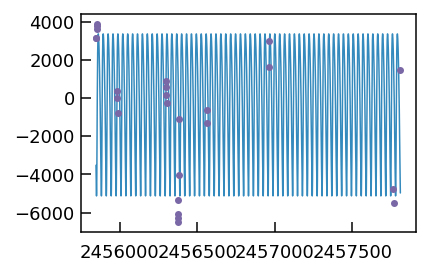

In [101]:
t_grid = Time(np.linspace(data_t.jd.min(), data_t.jd.max(), 10000), format='jd')
plt.plot(t_grid.jd, K*orbit.unscaled_radial_velocity(t_grid) + offset)
plt.errorbar(a.dates, rvs, sigs, marker='o', linestyle='none')

<Container object of 3 artists>

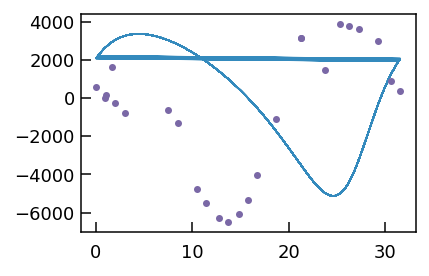

In [102]:
t_grid = Time(np.linspace(data_t.jd.min(), data_t.jd.max(), 10000), format='jd')
plt.plot( t_grid.jd % P, 
         K*orbit.unscaled_radial_velocity(t_grid) + offset)
plt.errorbar(a.dates % P, rvs, sigs, marker='o', linestyle='none')

In [106]:
pars0 = pack_keplerian_pars(P, K, e, omega, M0, offset)
soln = fit_keplerian(pars0, a.dates, rvs, sigs)
P, K, e, omega, M0, offset = unpack_keplerian_pars(soln)
print soln

[ 3.16431958e+01  4.63100254e+03  2.73022780e-01  4.34311408e+00
 -8.72594547e-01 -8.80517172e+02]


In [104]:
orbit = KeplerOrbit(P=P*u.day, e=e, omega=omega*u.rad, 
                    M0=M0*u.rad, Omega=0*u.deg, i=90*u.deg,
                    t0=t0_time)

<Container object of 3 artists>

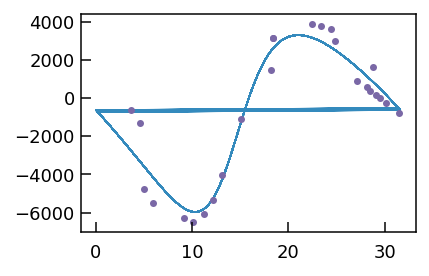

In [105]:
plt.plot( t_grid.jd % P, 
         K*orbit.unscaled_radial_velocity(t_grid) + offset)
plt.errorbar(a.dates % P, rvs, sigs, marker='o', linestyle='none')